# Project_3: Linear Regressions
## Author: Wing Yan Sang
## Date: 11/5/2017

<p><a name="sections"></a></p>


## Sections

- <a href="#split">Split Data</a><br>
- <a href="#preprocessing">Preprocessing</a><br>
 - <a href="#saleprice">Sale Price Log Transformation</a><br>
 - <a href="#imputation">Imputation</a><br>

 - <a href="#scaling">Scaling Select Features</a><br>
 - <a href="#YearBuilt">Group YearBuilt Feature</a><br> 
 - <a href="#subset">Subsetting the 20 Select Features</a><br>
 - <a href="#dummify1">Dummify Categorical Variables</a><br>

- <a href="#ordinals">EDA of ordinals/numeric</a><br>
- <a href="#linear1">Linear Regression 1</a><br>
 - <a href="#residuals_lin1">Residuals/Influence Analysis</a><br> 
 - <a href="#kaggle_1">Kaggle Submission</a><br>
 - <a href="#influence_1">Examine Outliers and Influential Datapoints</a><br>
 - <a href="#linear1_nooutliers">Linear Regression without Outliers</a><br>
 - <a href="#kaggle_1b">Kaggle Re-submission</a><br>
- <a href="#economy">EDA: Relationship between House Price and Economy</a><br>
- <a href="#categorical">EDA of Categoricals</a><br>
- <a href="#categorica_engineering">Features Engineering of Select Categoricals</a><br>
- <a href="#linear2">Linear Regression 2</a><br>
- <a href="#VIF1">VIF Analysis of Linear Regression 2 Model</a><br>
- <a href="#linear3">Linear Regression 3: All 20 Variables</a><br>
 - <a href="#VIF2">VIF of All 20 Variables</a><br>
 - <a href="#run_linear3">Run Regression</a><br>
 - <a href="#residuals_lin3">Residuals/Influence Analysis</a><br>
- <a href="#ridge">Ridge Regression</a><br>
 - <a href="#kaggle_2">Kaggle Submission</a><br>
 - <a href="#significance_ridge">Signficance Test</a><br>
 - <a href="#residuals_ridge">Residuals/Influence Analysis</a><br>
 - <a href="#impVar_ridge">Important Variables Analysis</a><br>
- <a href="#lasso">Lasso Regression</a><br> 
 - <a href="#kaggle_3">Kaggle Submission</a><br>
 - <a href="#significance_lasso">Signficance Test</a><br>
 - <a href="#residuals_lasso">Residuals/Influence Analysis</a><br>
 - <a href="#impVar_lasso">Important Variables Analysis</a><br>
 - <a href="#kaggle_3b">Kaggle Submission</a><br>

In [36]:
#### Loading the packages to be used
from __future__ import print_function 
import pandas as pd
import numpy as np
from scipy import stats

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import Ridge, Lasso, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
from  statsmodels.genmod import generalized_linear_model

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import seaborn as sns

<p><a name="split"></a></p>

## Split Dataset into Training and Test

In [37]:

pd.set_option('display.max_columns', 100)

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [38]:
# Save the 'Id' column
train_ID = train_df['Id']
test_ID = test_df['Id']
test_ID.to_csv('test_ID.csv', index = False, header = True)

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [39]:
y= train_df['SalePrice']
X_TRAIN = train_df.drop('SalePrice', axis=1)
X_TEST = test_df.copy()

- Delete the dataframes that you do not need anymore to save memory.

In [40]:
print(X_TRAIN.shape)
print(X_TEST.shape)

(1460, 79)
(1459, 79)


<p><a name="preprocessing"></a></p>
## Preprocess Training and Test Sets

<p><a name="saleprice"></a></p>
### Sale Price: Log Transform

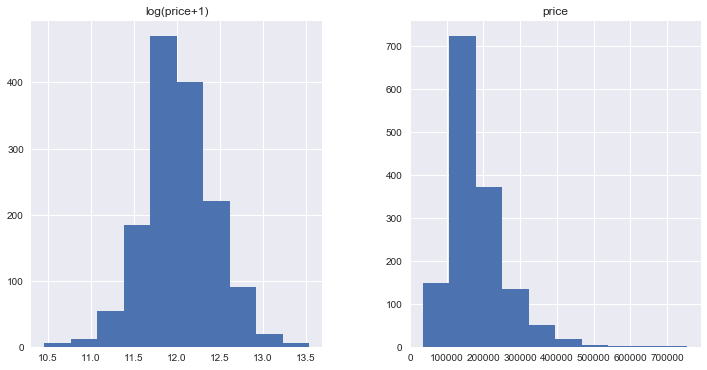

In [41]:
#Inspect distribution of sales prices. Seems that log transformation can make the sales price more "normal".
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":y, "log(price+1)":np.log1p(y)})
prices.hist()

#log transform the target:
y = np.log1p(y)

<p><a name="imputation"></a></p>
### Imputation

In [42]:
# Idea borrowed from this script: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard


def impute(all_data):

	# PoolQC : data description says NA means "No Pool". That make sense, given the huge ratio of missing value (+99%) and majority of houses have no Pool at all in general.
	all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

	# MiscFeature : data description says NA means "no misc feature"
	all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

	# Alley : data description says NA means "no alley access"
	all_data["Alley"] = all_data["Alley"].fillna("None")

	# Fence : data description says NA means "no fence"
	all_data["Fence"] = all_data["Fence"].fillna("None")

	# FireplaceQu : data description says NA means "no fireplace"
	all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

	# LotFrontage : Since the area of each street connected to the house property most likely have a similar area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
	# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
	all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

	# GarageType, GarageFinish, GarageQual and GarageCond : Replacing missing data with None
	for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
		all_data[col] = all_data[col].fillna('None')

	# GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
	for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
		all_data[col] = all_data[col].fillna(0)

	# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
	for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
		all_data[col] = all_data[col].fillna(0)

	# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : For all these categorical basement-related features, NaN means that there is no basement.
	for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
		all_data[col] = all_data[col].fillna('None')

	# MasVnrArea and MasVnrType : NA most likely means no masonry veneer for these houses. We can fill 0 for the area and None for the type.
	all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
	all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

	# MSZoning (The general zoning classification) : 'RL' is by far the most common value. So we can fill in missing values with 'RL'
	all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

	# Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
	all_data = all_data.drop(['Utilities'], axis=1)

	# Functional : data description says NA means typical
	all_data["Functional"] = all_data["Functional"].fillna("Typ")

	# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
	all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

	# KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.
	all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

	# Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
	all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
	all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

	# SaleType : Fill in again with most frequent which is "WD"
	all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

	# MSSubClass : Na most likely means No building class. We can replace missing values with None
	all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")
	
	# Adding total sqfootage feature 
	all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

	# Transforming some numerical variables that are really categorical

	#MSSubClass=The building class
	all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

	#Changing OverallCond into a categorical variable
	all_data['OverallCond'] = all_data['OverallCond'].astype(str)

	#Year and month sold are transformed into categorical features.
	all_data['YrSold'] = all_data['YrSold'].astype(str)
	all_data['MoSold'] = all_data['MoSold'].astype(str)

	return all_data


In [43]:
impute(X_TRAIN)
impute(X_TEST)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,20,RH,80.0,11622,Pave,None,Reg,Lvl,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,None,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,None,MnPrv,None,0,6,2010,WD,Normal,1778.0
1,20,RL,81.0,14267,Pave,None,IR1,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,None,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,None,None,Gar2,12500,6,2010,WD,Normal,2658.0
2,60,RL,74.0,13830,Pave,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,None,MnPrv,None,0,3,2010,WD,Normal,2557.0
3,60,RL,78.0,9978,Pave,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,None,None,None,0,6,2010,WD,Normal,2530.0
4,120,RL,43.0,5005,Pave,None,IR1,HLS,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,None,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,None,None,None,0,1,2010,WD,Normal,2560.0
5,60,RL,75.0,10000,Pave,None,IR1,Lvl,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,None,None,None,0,4,2010,WD,Normal,2418.0
6,20,RL,63.0,7980,Pave,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,None,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,None,GdPrv,Shed,500,3,2010,WD,Normal,2355.0
7,60,RL,63.0,8402,Pave,None,IR1,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,None,None,None,0,5,2010,WD,Normal,2254.0
8,20,RL,85.0,10176,Pave,None,Reg,Lvl,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,None,None,None,0,2,2010,WD,Normal,2641.0
9,20,RL,70.0,8400,Pave,None,Reg,Lvl,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,Plywood,Plywood,None,0.0,

<p><a name="scaling"></a></p>
### Scaling and Unskewing Select Variables
Scaling the numeric variables among the selected 20 variables.

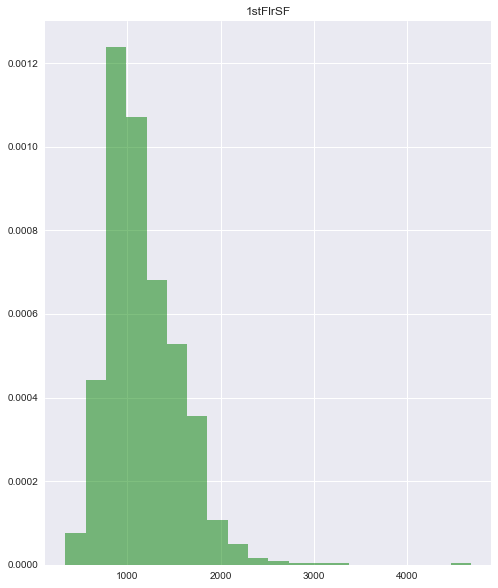

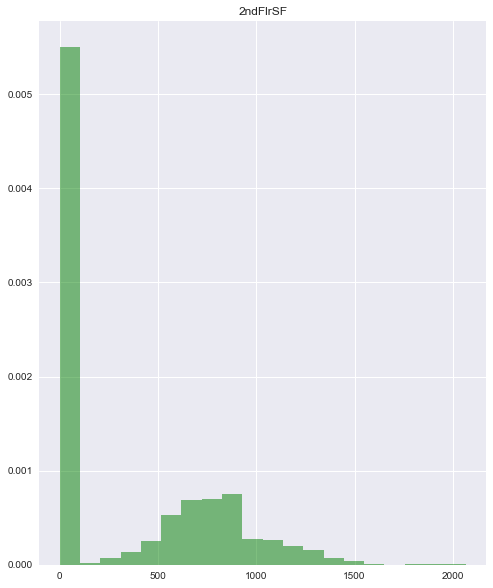

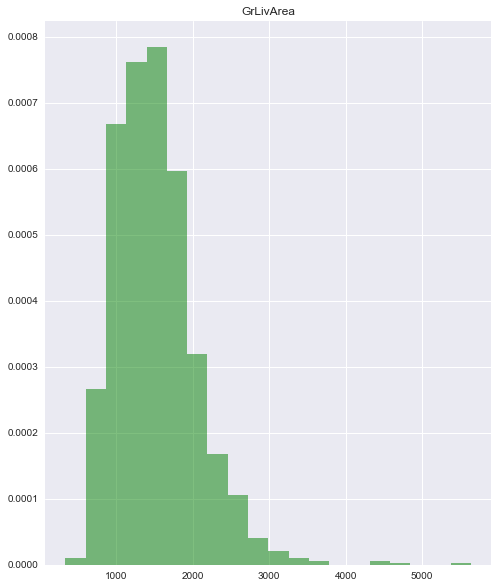

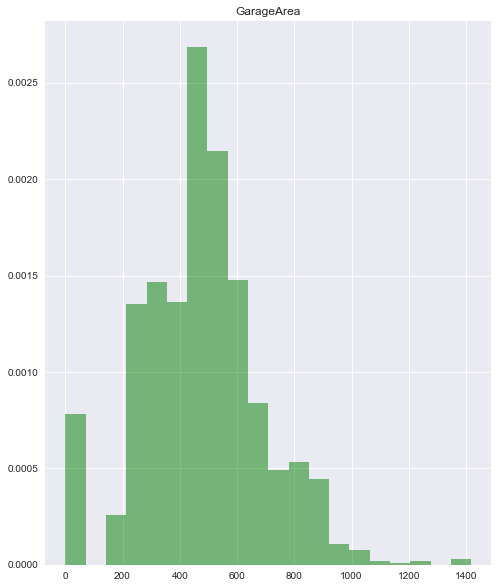

In [46]:
#Plot histograms of numeric variables in test set
columns_num =['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']
for col in columns_num: 
    plt.figure(figsize=(8, 10)) 
    plt.hist(X_TRAIN[col], bins = 20, normed=1, facecolor='green', alpha=0.5)
    plt.title(col) 
    plt.show()
    


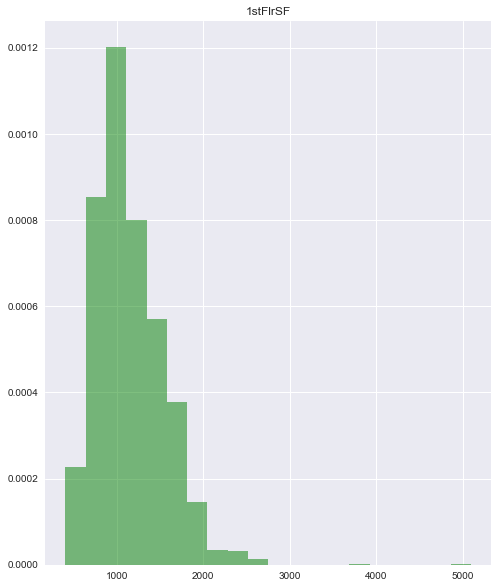

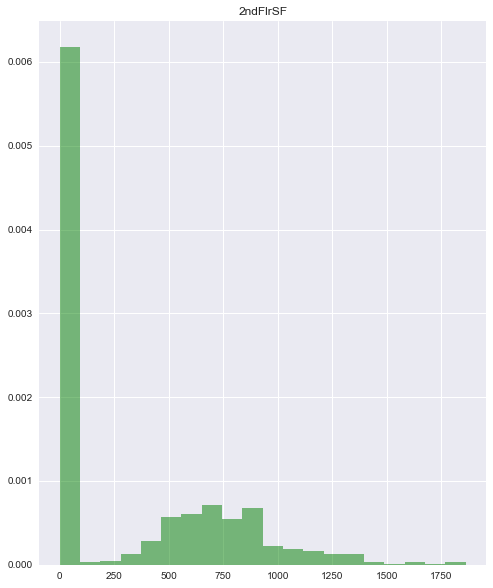

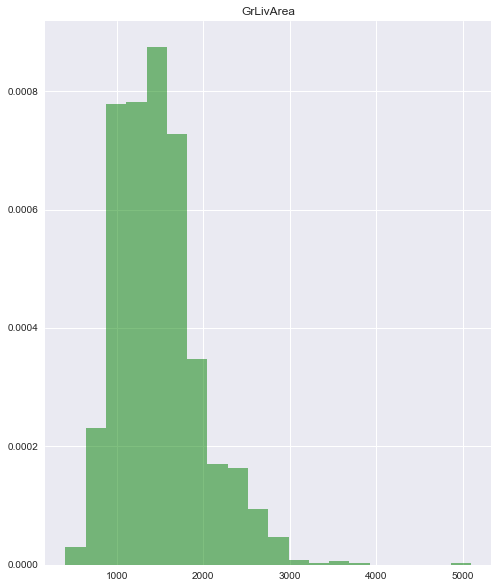

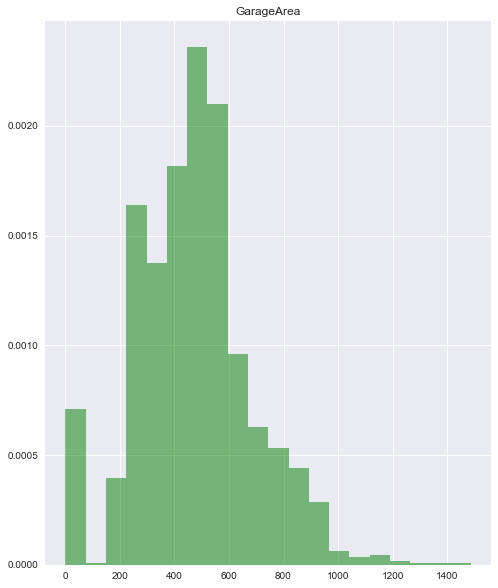

In [47]:
#Plot histograms of numeric variables in test set
columns_num =['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']
for col in columns_num: 
    plt.figure(figsize=(8, 10)) 
    plt.hist(X_TEST[col], bins = 20, normed=1, facecolor='green', alpha=0.5)
    plt.title(col) 
    plt.show()
    

In [48]:
#Print skewness of selected numerical variables in training set
for col in columns_num:  
    print(X_TRAIN[col].skew())
print (columns_num)

1.37675662203
0.813029816302
1.36656035602
0.179980906746
['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']


In [49]:
#Print skewness of selected numerical variables in test set
for col in columns_num:  
    print(X_TEST[col].skew())
print (columns_num)

1.55819457298
0.912882634491
1.13040241405
0.296290305968
['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']


In [50]:
#Correct skewness of 1stFlrSF and GrLivArea in test and training sets
a = np.log(X_TRAIN['1stFlrSF'])
b = np.log(X_TEST['1stFlrSF'])
c = np.log(X_TRAIN['GrLivArea'])
d = np.log(X_TEST['GrLivArea'])

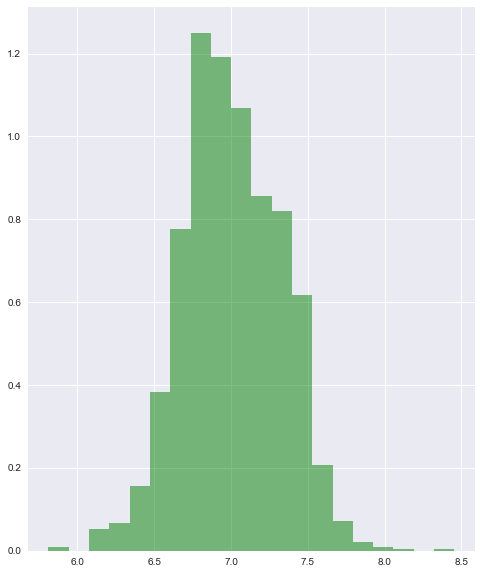

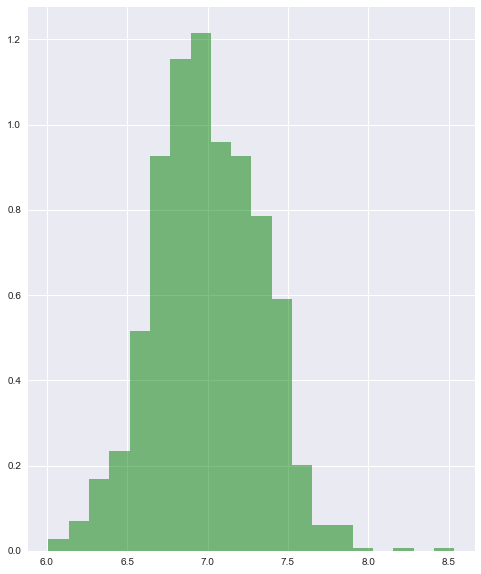

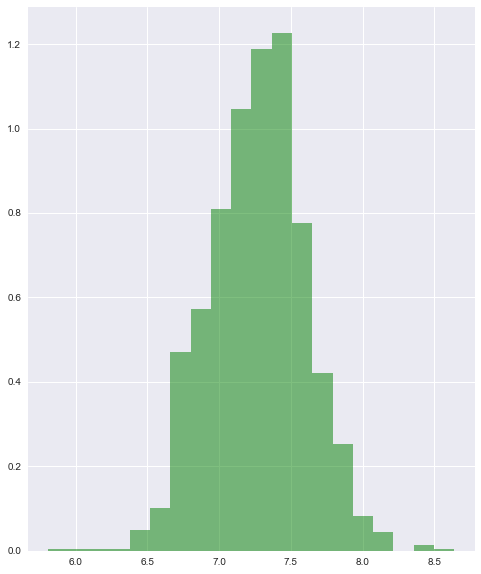

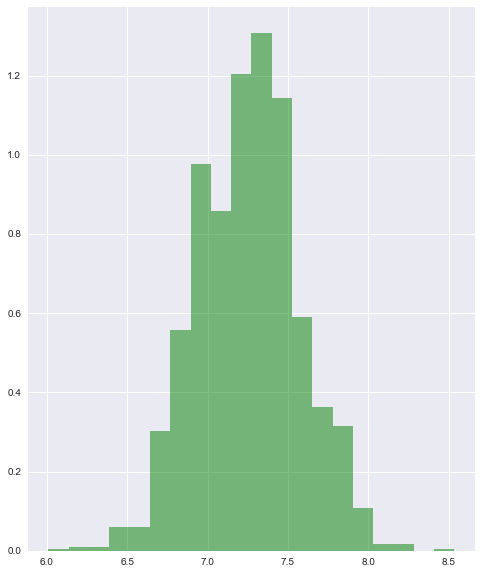

In [51]:
#examine unskewed data
columns_unskewed =[a, b, c, d]
for col in columns_unskewed: 
    plt.figure(figsize=(8, 10)) 
    plt.hist(col, bins = 20, normed=1, facecolor='green', alpha=0.5)
    plt.show()
    

In [52]:
#assign the unskewed values to the test and training sets
X_TRAIN['1stFlrSF'] = a
X_TEST['1stFlrSF'] =b
X_TRAIN['GrLivArea'] =c 
X_TEST['GrLivArea'] = d


In [53]:
#Scale numeric variables using normal distribution

C =X_TRAIN.copy()
D =X_TEST.copy()
scaler = preprocessing.StandardScaler()

columns_num =['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']
scaled_df =pd.DataFrame()
for col in columns_num: 
    C[col] = scaler.fit_transform(X_TRAIN[col].values.reshape(-1,1))
    D[col] = scaler.transform(X_TEST[col].values.reshape(-1,1))


/Users/wingyansang/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [54]:
#Setting training and test sets equal to the scaled data frames (C and D)
X_TRAIN = C
X_TEST = D


In [55]:
del C
del D

<p><a name="YearBuilt"></a></p>
### Group YearBuilt Feature into Categories

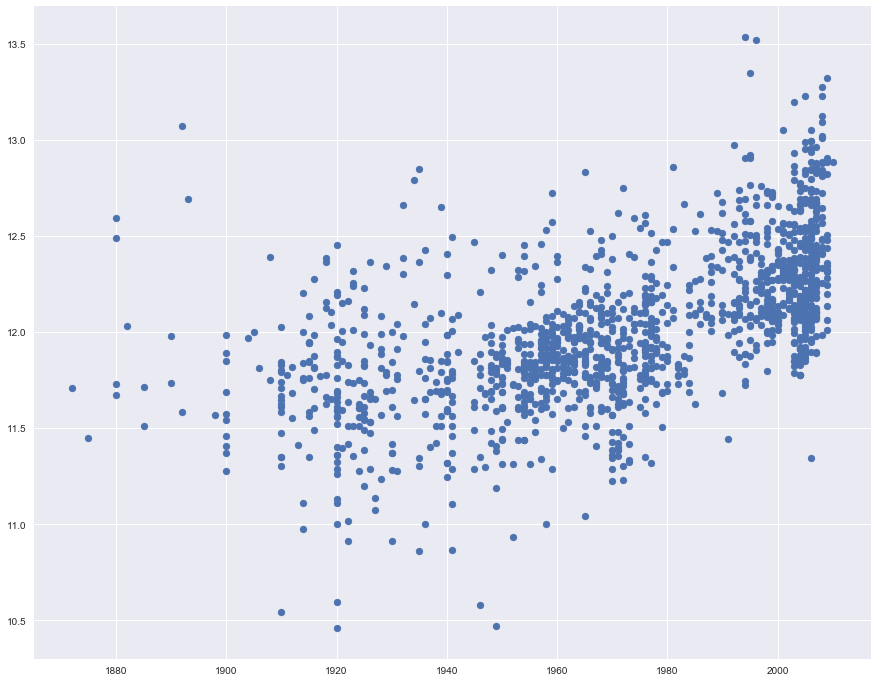

In [56]:
#Plot YrBuilt against SalePrice
fig = plt.figure(figsize=(15, 12))
plt.scatter(X_TRAIN['YearBuilt'], y)
plt.show()

In [57]:
#Change YearBuilt column into 6 groups

def yrBuilt(c):
    if c['YearBuilt'] <=1900:
        return 'to1900'
    elif c['YearBuilt'] <=1920:
        return 'to1920'
    elif c['YearBuilt'] <=1945:
        return 'to1945'
    elif c['YearBuilt'] <=1965:
        return 'to1965'
    elif c['YearBuilt'] <=1980:
        return 'to1980'
    elif c['YearBuilt'] <=2000:
        return 'to2000'
    else:
        return 'toPresent'
    
X_TRAIN['YearBuilt'] = X_TRAIN.apply(yrBuilt, axis=1)


In [58]:
X_TEST['YearBuilt'] = X_TEST.apply(yrBuilt, axis=1)

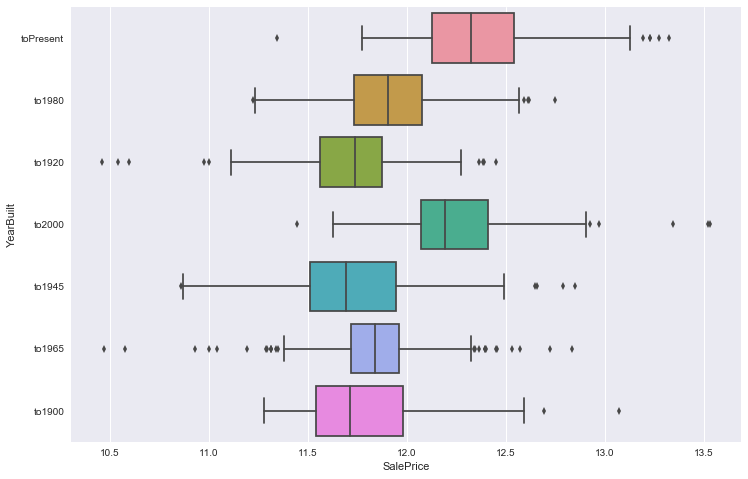

In [59]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot(y, X_TRAIN['YearBuilt'])
plt.show()

<p><a name="subset"></a></p>
### Create Subset of 20 Variables Chosen by Team

In [60]:
train_sub = pd.read_csv("train_sub.csv")
train_sub.rename(columns = {'X1stFlrSF': '1stFlrSF', 'X2ndFlrSF': '2ndFlrSF'}, inplace = True)
train_sub = train_sub.drop("SalePrice", axis = 1)

In [61]:
#train_sub and test_sub are the scaled and imputed data frames of just the 20 variables. 
#Used in Linear Regression 1

colSelected = list(train_sub.columns)
train_sub = pd.DataFrame()
test_sub = pd.DataFrame()
for i in colSelected:
    train_sub[i] =X_TRAIN[i]
    test_sub[i] = X_TEST[i]


<p><a name="dummify1"></a></p>
### Dummify Variables
Dummify categorical variables among the top 20

In [62]:
#concatenate the training and test subsets before dummification
all_sub = pd.concat([train_sub, test_sub])
all_sub.shape

(2919, 21)

In [63]:
#dummify the variables
all_sub = pd.get_dummies(all_sub, drop_first=True, dummy_na=False)

In [64]:
#dummify numerical variables that are actually categorical features: OverallQual, FullBath, GarageCars,
#and TotRmsAbvGrd
A = pd.DataFrame(all_sub[['GarageCars', 'OverallQual', 'FullBath', 'TotRmsAbvGrd']])

In [65]:
cars = pd.get_dummies(A['GarageCars'], prefix='cars', prefix_sep='__')
cars = cars.drop('cars__0.0', axis=1)
qual = pd.get_dummies(A['OverallQual'], prefix='qual', prefix_sep='__')
qual = qual.drop('qual__1', axis=1)
bath = pd.get_dummies(A['FullBath'], prefix='bath', prefix_sep='__')
bath = bath.drop('bath__1', axis=1)
rooms = pd.get_dummies(A['TotRmsAbvGrd'], prefix='rooms', prefix_sep='__')
rooms = rooms.drop('rooms__2', axis=1)
all_sub = pd.concat([all_sub,cars,qual,bath,rooms], axis = 1)
all_sub = all_sub.drop(['GarageCars', 'OverallQual', 'FullBath', 'TotRmsAbvGrd'],axis = 1)

In [66]:
del A

<p><a name="ordinals"></a></p>

## EDA of Numeric/Ordinals Variables

EDA of the following Numeric Variables: "GrLivArea", "FullBath", "TotRmsAbvGrd", "GarageCars", "GarageArea"

In [67]:
#split into numeric and categorical features and observed values
X_num = train_df[["GrLivArea", "1stFlrSF", "2ndFlrSF", "GarageArea"]]
X_cat = pd.concat([train_df["YearBuilt"],train_sub.drop(["GrLivArea", "1stFlrSF", "2ndFlrSF", "GarageArea",
                    "YearBuilt"], axis = 1)], axis = 1)
del train_df


In [68]:
#Inspect the numeric features
X_num.describe()

,GrLivArea,1stFlrSF,2ndFlrSF,GarageArea
count,1460.000000,1460.000000,1460.000000,1460.000000
mean,1515.463699,1162.626712,346.992466,472.980137
std,525.480383,386.587738,436.528436,213.804841
min,334.000000,334.000000,0.000000,0.000000
25%,1129.500000,882.000000,0.000000,334.500000
50%,1464.000000,1087.000000,0.000000,480.000000
75%,1776.750000,1391.250000,728.000000,576.000000
max,5642.000000,4692.000000,2065.000000,1418.000000


/Users/wingyansang/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """


0.46899747732296548

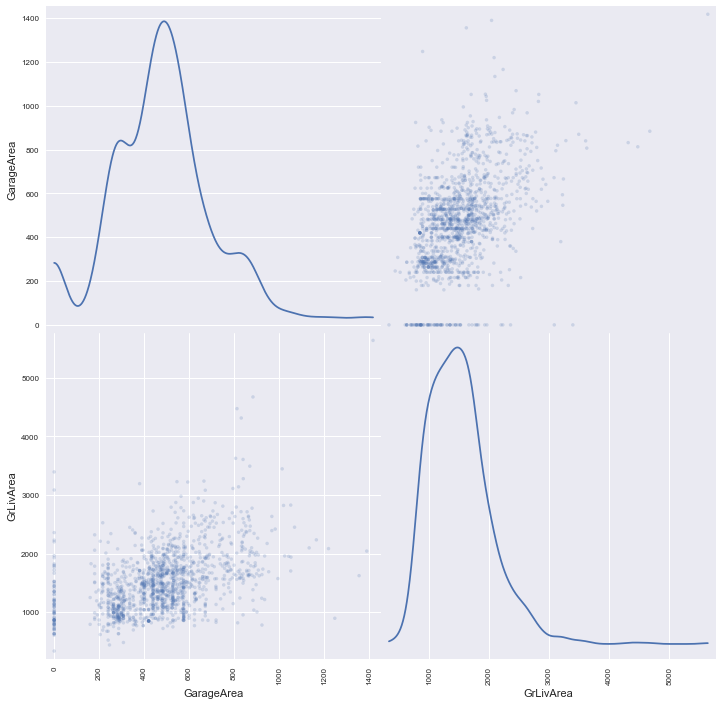

In [69]:
#Check for multicollinearity between GarageArea and GrLivArea. Scatter shows vague linear relationship. 
#Correlation is 0.46899

from pandas.tools.plotting import scatter_matrix
scatter_matrix(X_num[["GarageArea","GrLivArea"]], alpha=0.2, figsize=(12, 12), diagonal='kde')
plt.savefig('num_scatter.png')
np.corrcoef(X_num["GarageArea"], X_num["GrLivArea"])[0, 1]

<p><a name="categorical"></a></p>

## EDA of Categorical Variables

EDA of categorical variables to examine relationship with SalePrice and with each other. 


In [70]:
#View the Categorical Variables
X_cat.head()

,YearBuilt,MSZoning,Neighborhood,HouseStyle,OverallQual,ExterQual,Foundation,BsmtQual,FullBath,TotRmsAbvGrd,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,2003,RL,CollgCr,2Story,7,Gd,PConc,Gd,2,8,RFn,2,TA,TA,Y,WD,Normal
1,1976,RL,Veenker,1Story,6,TA,CBlock,Gd,2,6,RFn,2,TA,TA,Y,WD,Normal
2,2001,RL,CollgCr,2Story,7,Gd,PConc,Gd,2,6,RFn,2,TA,TA,Y,WD,Normal
3,1915,RL,Crawfor,2Story,7,TA,BrkTil,TA,1,7,Unf,3,TA,TA,Y,WD,Abnorml
4,2000,RL,NoRidge,2Story,8,Gd,PConc,Gd,2,9,RFn,3,TA,TA,Y,WD,Normal


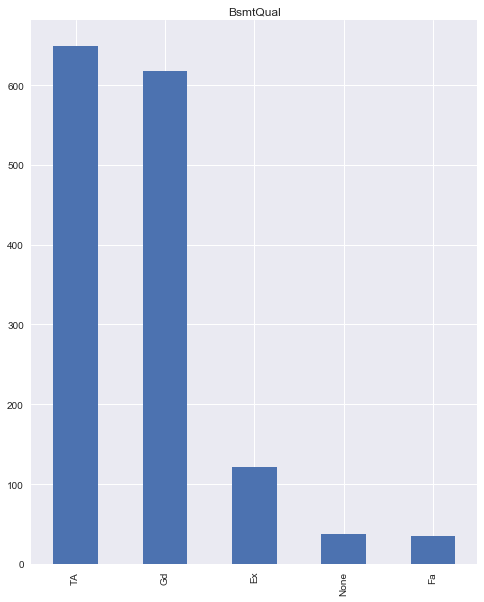

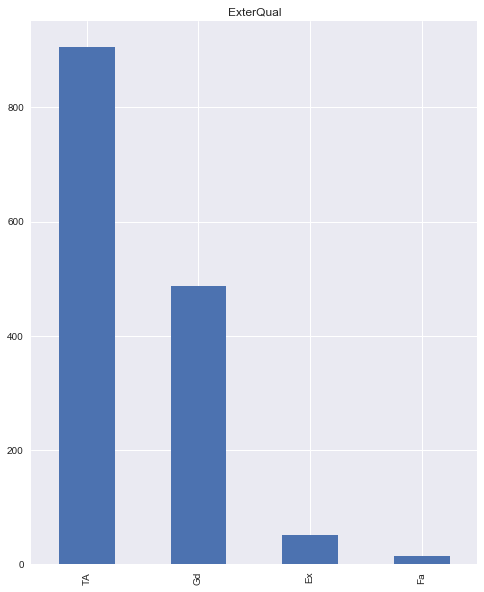

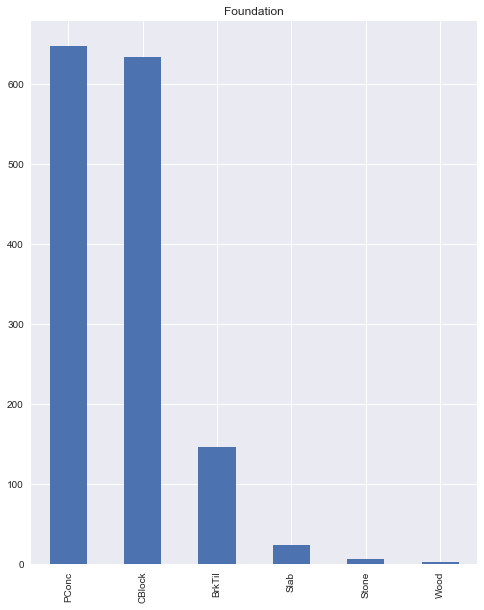

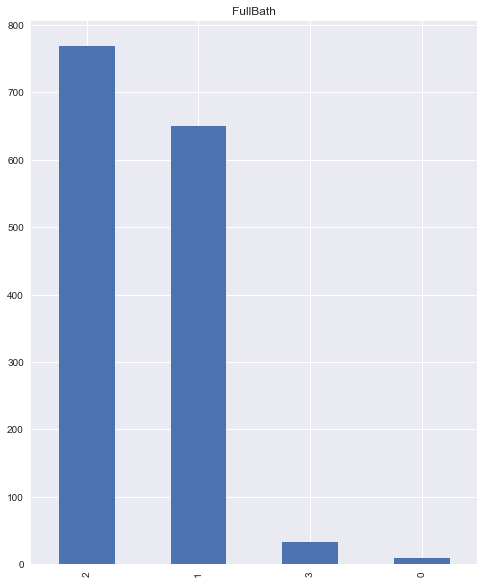

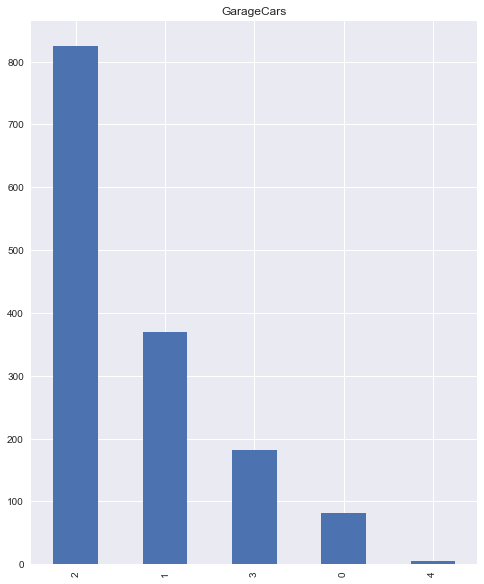

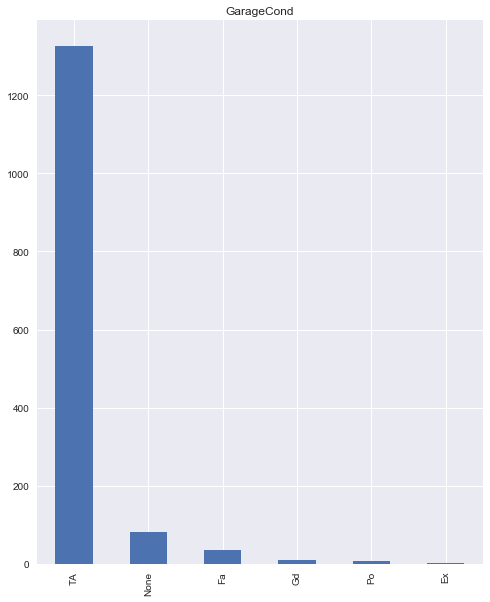

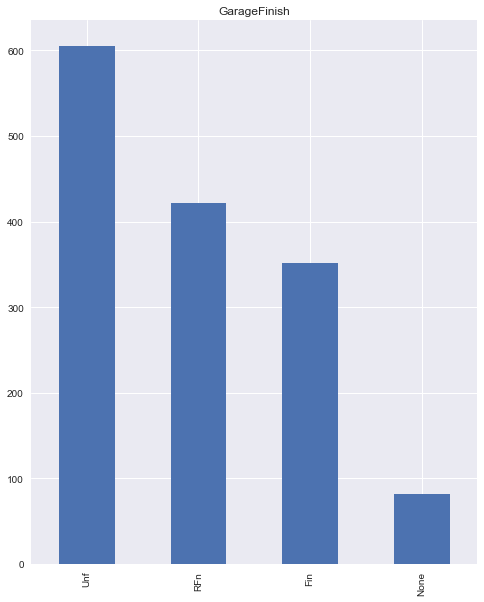

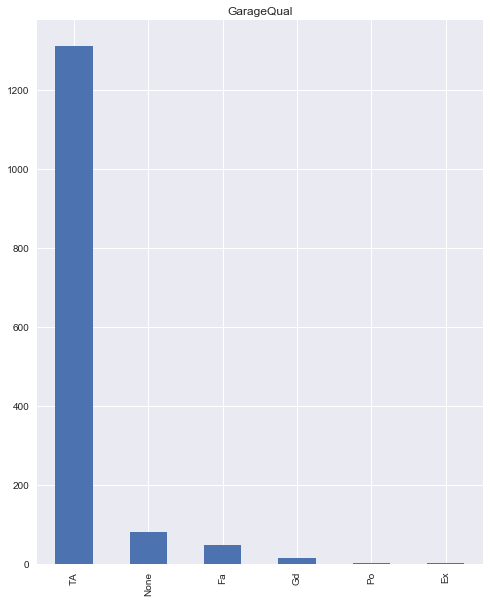

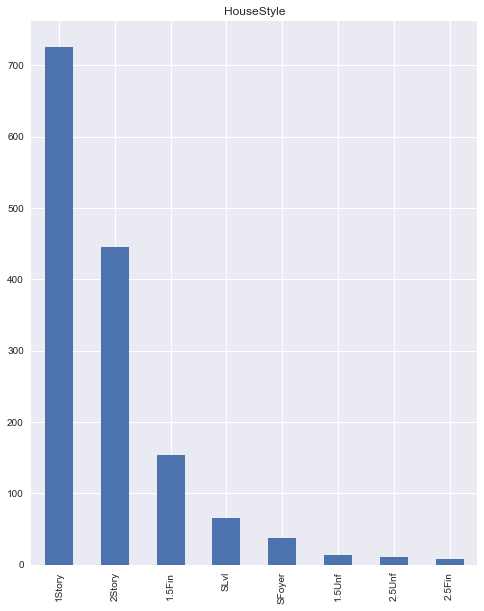

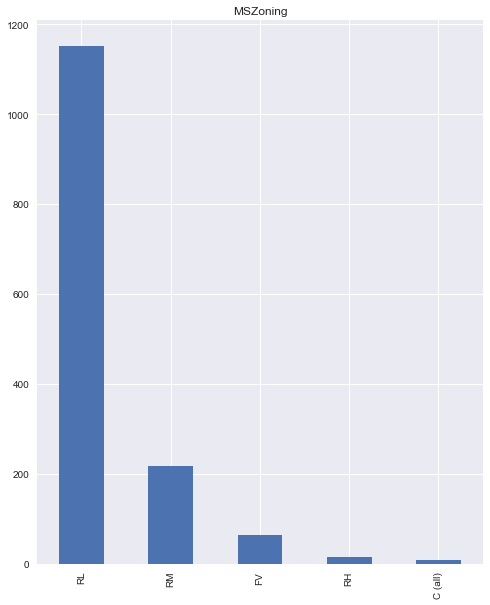

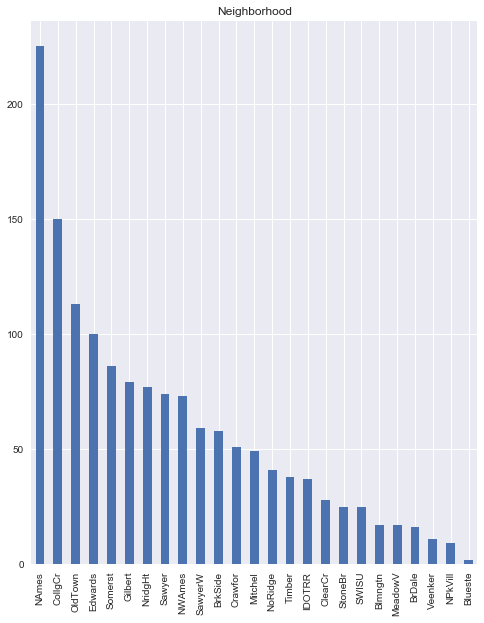

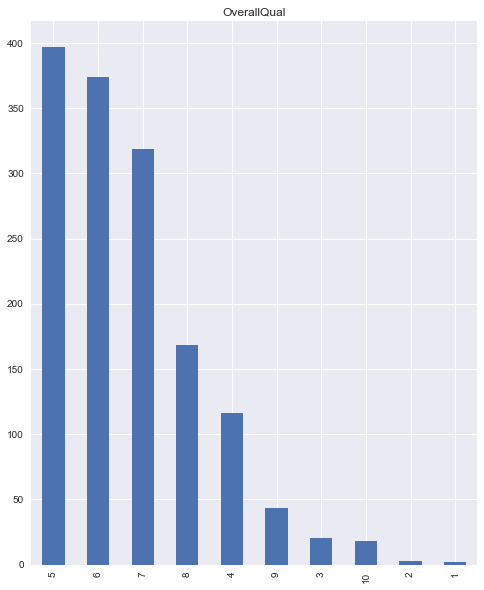

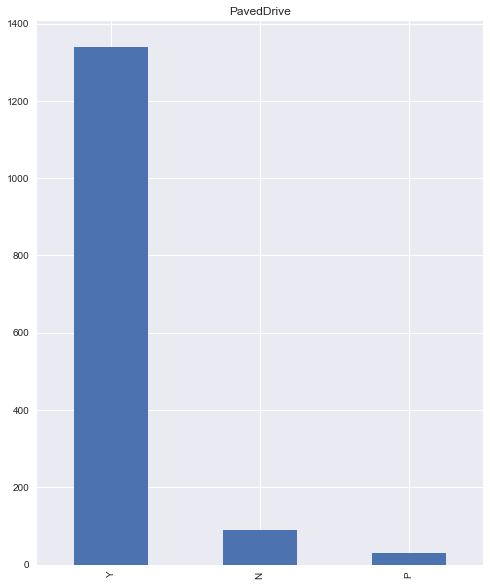

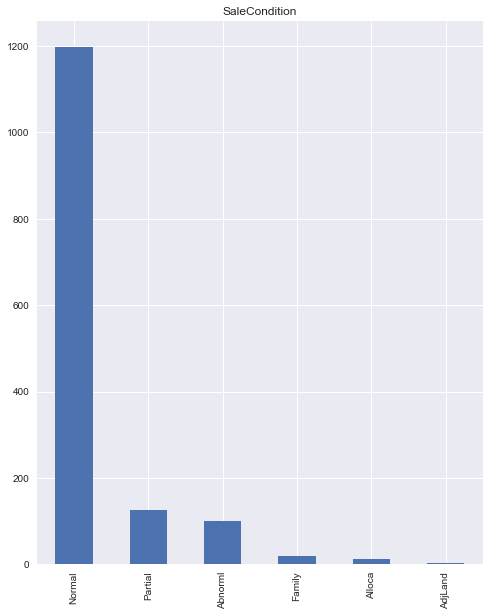

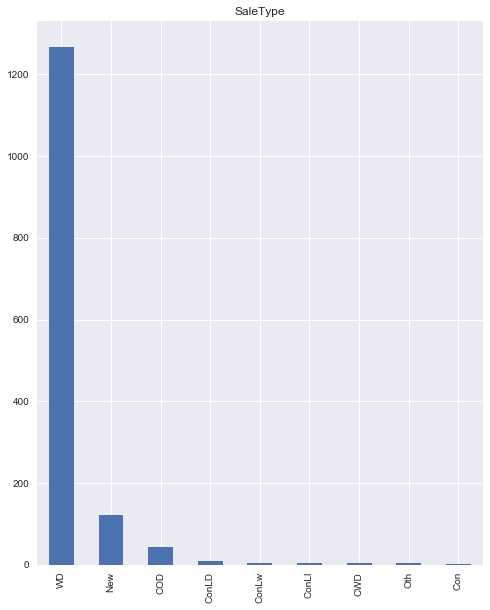

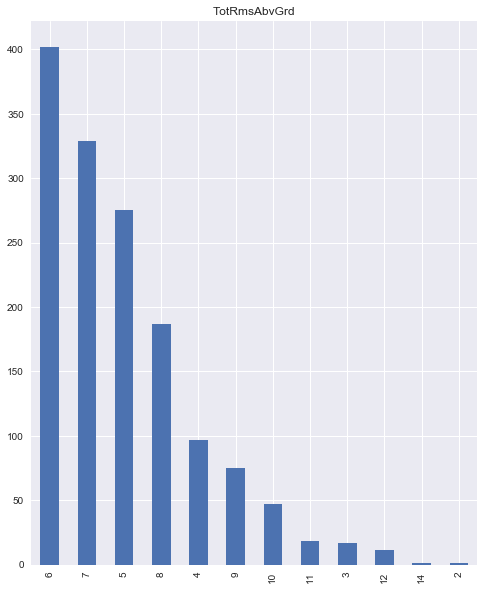

(array([   2.,    4.,    3.,    2.,    3.,    1.,   11.,    4.,   22.,
          26.,   54.,   42.,   26.,   22.,   35.,   23.,   58.,   47.,
         100.,   66.,   95.,   94.,   83.,   46.,   23.,   34.,   82.,
          88.,  206.,  158.]),
 array([ 1872. ,  1876.6,  1881.2,  1885.8,  1890.4,  1895. ,  1899.6,
         1904.2,  1908.8,  1913.4,  1918. ,  1922.6,  1927.2,  1931.8,
         1936.4,  1941. ,  1945.6,  1950.2,  1954.8,  1959.4,  1964. ,
         1968.6,  1973.2,  1977.8,  1982.4,  1987. ,  1991.6,  1996.2,
         2000.8,  2005.4,  2010. ]),
 <a list of 30 Patch objects>)

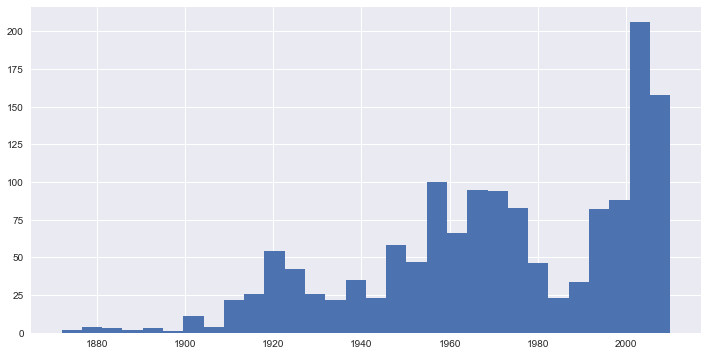

In [71]:
#Bar charts of the categorical variables
#For quality variables, the middle value (typical) dominates, then the second is good.
#GarageFinish is dominated by Unfinished and Rough Finish
#HouseStyle can be broken up into >=2Flr, <=1 1Flr, SplitLevel
#MSZoning dominated by Residential(Low and Medium Density)
#Will need to do further analysis on Neighborhood to see if it values can be combined.
#Sale Type/SaleCondition dominated by Warranty Deed and Normal
#Many homes built after 1990

for idx, col in zip(range(1, len(X_cat.columns)),X_cat.columns.sort_values()): 
    plt.figure(figsize=(8, 10)) 
    X_cat[col].value_counts().plot(kind='bar', )
    plt.title(col) 
    plt.show()
    
plt.hist(X_cat["YearBuilt"], bins=30) 
    


<p><a name="categorical_engineering"></a></p>

## EDA and Features Engineering of Select Categorical Variables

EDA and features engineering of the following categorical variables:
"Neighborhood", "OverallQual", "HouseStyle", "SaleCondition".


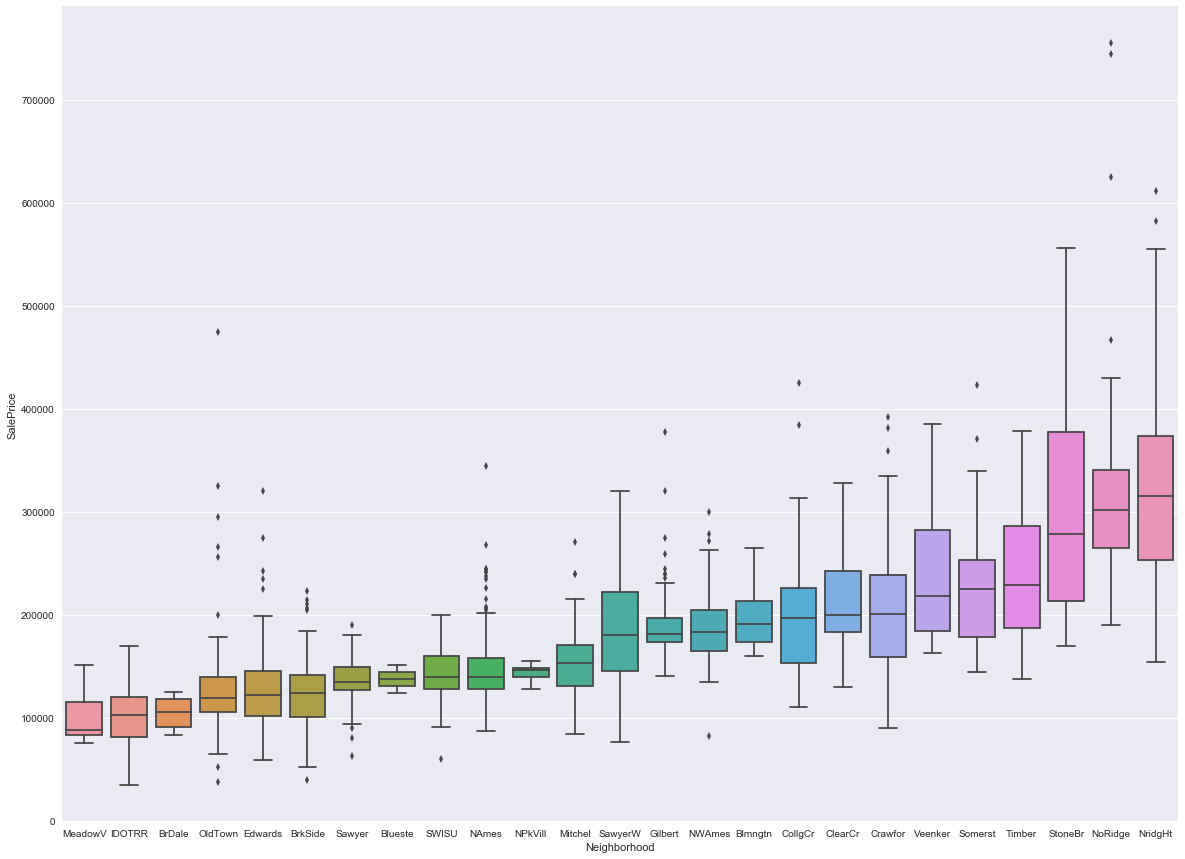

In [94]:
#Boxplot of sales price by neighborhood. 
#Seems like there are big ranges for neighborhoods at the top end of the market whereas ranges are smaller 
#at bottom neighborhoods. Also there are quite a few outliers. May have to remove them to prevent overfitting.
train_df = pd.read_csv('train.csv')
m = train_df.groupby(['Neighborhood'])['SalePrice'].apply(np.median)
m.name = 'MEDIAN'
m = m.sort_values()
m.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_df["SalePrice"], x=train_df["Neighborhood"], order = m.index)
sns.set(font_scale= 3.0) 

In [73]:
#Examine quartile ranges and group them
pd.qcut(m, 4)
x = pd.DataFrame(pd.qcut(m, 4))
x.columns.values[0] = "quartiles"
s = [i for i in range(1,5) for _ in range(6)]
s.insert(0,1)
x["Group"] = s
x.columns.values[1] = "Neigh_Group"
x['Neighborhood'] = x.index.tolist()


In [74]:
#Add Neigh_Group column to train_sub data frame. Count the frequency of each group. 
#Lower value homes most frequent. Higher valued homes least frequent.

new_df = pd.merge(train_sub, x, how='left', on = ["Neighborhood", "Neighborhood"])
new_df = new_df.drop("quartiles",1)
train_sub = new_df
train_sub.groupby("Neigh_Group").size()


Neigh_Group
1    415
2    369
3    398
4    278
dtype: int64

In [75]:
#Group HouseStyle variable by 1stFloor, 2ndFloor, and Split and count frequency. 1Story and 2Story close.

def hstyle(c):
    if c['HouseStyle'] == "1Story":
        return '1Story'
    elif c['HouseStyle'] in ["SFoyer", "SLvl"]:
        return 'Split'
    else:
        return '2Story'

train_sub['House_Group'] = train_sub.apply(hstyle, axis=1)
train_sub.groupby("House_Group").size()

House_Group
1Story    726
2Story    632
Split     102
dtype: int64

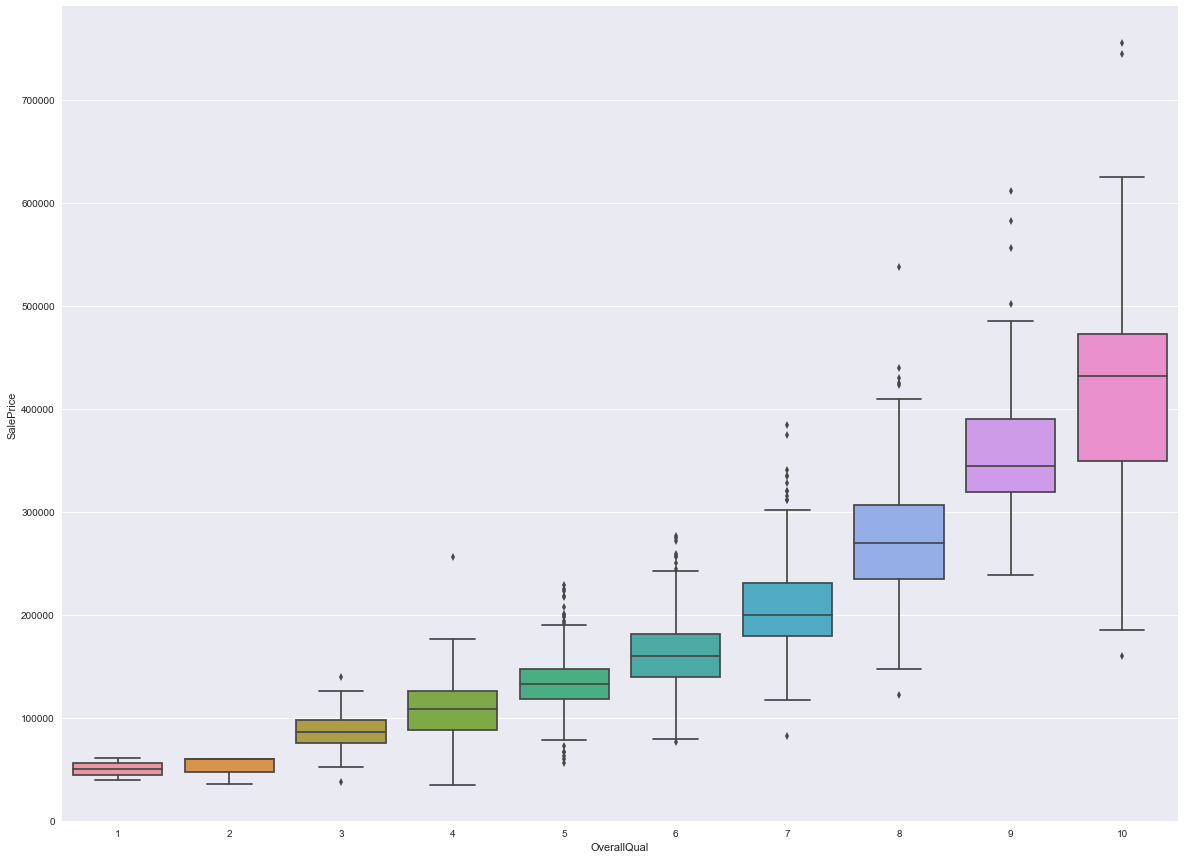

In [129]:
#Boxplot of sales price by OverallQual. As quality goes up, sales price goes up.
#Similar to Neighborhood analysis, there are bigger ranges the higher the quality. 
#Also there are quite a few outliers towards right side of chart.

n = train_df.groupby(['OverallQual'])['SalePrice'].apply(np.median)
n.name = 'MEDIAN'
n = n.sort_values()
n.index


fig = plt.figure(figsize=(20, 15))
sns.boxplot(y=train_df["SalePrice"], x=train_df["OverallQual"], order = n.index)
sns.set(font_scale=.5)  

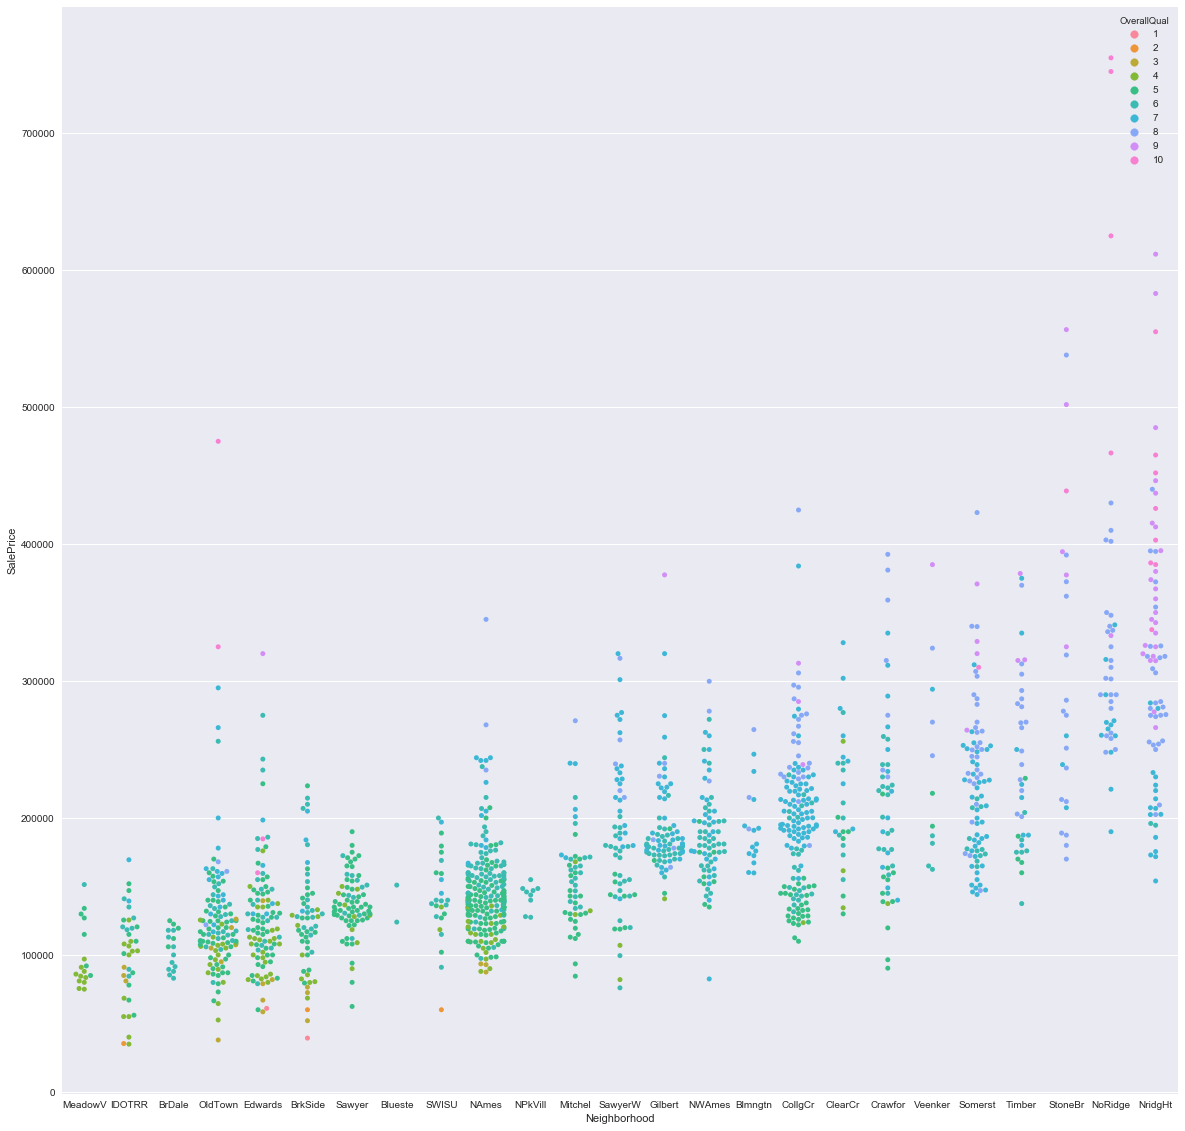

In [103]:
#Examine relationship between Neighborhood, OverallQual, and SalePrice. Lower quality (olive green, green) 
#corresponds to lower price and certain neigborhoods. Same for higher quality homes (violet, pinkish, light blue).

plt.figure(figsize=(20,20))
sns.swarmplot(x = 'Neighborhood', y = 'SalePrice', data=train_df, hue='OverallQual',order = m.index)
sns.set(font_scale=1) 

In [104]:
#Crosstab also shows some relationship between the Neigh_Group and OverallQual

pd.crosstab(train_sub["Neigh_Group"], train_sub["OverallQual"])


OverallQual,1,2,3,4,5,6,7,8,9,10
Neigh_Group,,,,,,,,,,
1,2,2,17,83,182,94,27,3,1,4
2,0,1,3,27,152,135,42,9,0,0
3,0,0,0,6,56,122,169,41,4,0
4,0,0,0,0,7,23,81,115,38,14


In [105]:
#Examine the quantiles of OverallQual
qual_cut = pd.DataFrame(pd.qcut(n, 3))
qual_cut

,MEDIAN
OverallQual,
1,"(50149.999, 108000.0]"
2,"(50149.999, 108000.0]"
3,"(50149.999, 108000.0]"
4,"(50149.999, 108000.0]"
5,"(108000.0, 200141.0]"
6,"(108000.0, 200141.0]"
7,"(108000.0, 200141.0]"
8,"(200141.0, 432390.0]"
9,"(200141.0, 432390.0]"


In [106]:
#Add column that groups OverallQual into thirds

def overall_qual(c):
    if c['OverallQual'] <= 4:
        return 'Low'
    elif c['OverallQual'] > 7:
        return 'High'
    else:
        return 'Medium'

train_sub['Qual_Group'] = train_sub.apply(overall_qual, axis=1)
train_sub.groupby("Qual_Group").size()

Qual_Group
High       229
Low        141
Medium    1090
dtype: int64

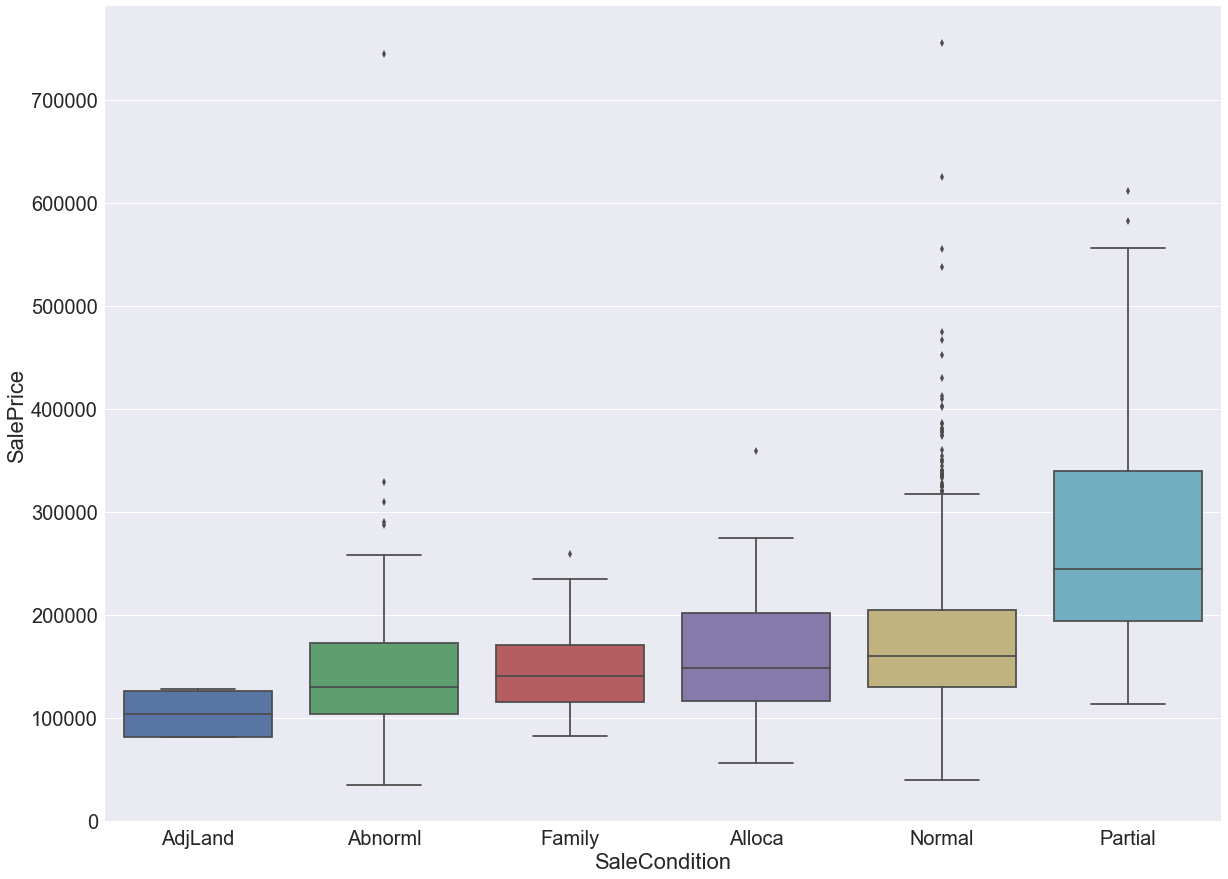

In [112]:
#Boxplot of sales price by SaleCondition. 

n2 = train_df.groupby(['SaleCondition'])['SalePrice'].apply(np.median)
n2.name = 'MEDIAN'
n2 = n2.sort_values()
n2.index


fig = plt.figure(figsize=(20, 15))
sns.set(font_scale= 2.0) 
sns.boxplot(y=train_df["SalePrice"], x=train_df["SaleCondition"], order = n2.index)


In [113]:
#Examine the quantiles of SaleCondition
pd.qcut(n2, 3)

SaleCondition
AdjLand    (103999.999, 137000.0]
Abnorml    (103999.999, 137000.0]
Family     (137000.0, 152096.667]
Alloca     (137000.0, 152096.667]
Normal     (152096.667, 244600.0]
Partial    (152096.667, 244600.0]
Name: MEDIAN, dtype: category
Categories (3, interval[float64]): [(103999.999, 137000.0] < (137000.0, 152096.667] < (152096.667, 244600.0]]

In [116]:
#Add column that groups SaleCondition into tw0

def saleCond(c):
    if c['SaleCondition'] == "Partial":
        return 'Partial'
    else:
        return 'Non_partial'

train_sub['SaleCond_Group'] = train_sub.apply(saleCond, axis=1)
train_sub.groupby("SaleCond_Group").size()

SaleCond_Group
Non_partial    1335
Partial         125
dtype: int64

In [117]:
#dummify Neigh_Group
df = train_sub.copy()
hood = pd.get_dummies(df['Neigh_Group'], prefix='Neigh', prefix_sep='__')
hood = hood.drop('Neigh__1', axis=1)
hood.head()
df = pd.concat([df.drop('Neigh_Group', axis=1), hood], axis=1)



In [118]:
#dummify HouseStyle
df = df.copy()
style = pd.get_dummies(df['House_Group'], prefix='Style', prefix_sep='__')
style = style.drop('Style__1Story', axis=1)
df = pd.concat([df.drop('House_Group', axis=1), style], axis=1)



In [119]:
#dummify OverallQual
df = df.copy()
qual = pd.get_dummies(df['Qual_Group'], prefix='Qual', prefix_sep='__')
qual = qual.drop('Qual__Low', axis=1)
df = pd.concat([df.drop('Qual_Group', axis=1), qual], axis=1)

In [120]:
#dummify SaleCond
df = df.copy()
saleCond = pd.get_dummies(df['SaleCond_Group'], prefix='saleCond', prefix_sep='__')
saleCond = saleCond.drop('saleCond__Non_partial', axis=1)
df = pd.concat([df.drop('SaleCond_Group', axis=1), saleCond], axis=1)

<p><a name="linear1"></a></p>

## Linear Regression 1

Linear regression using the following variables: "GrLivArea", "Neighborhood", "OverallQual", 
"HouseStyle", "SaleCondition".

In [183]:
#Select five variables to perform linear regression
X5 = pd.concat([df[["GrLivArea"]],df[df.columns[-8:]]], axis = 1)

In [184]:
#Split train_sub into train and test and fit 2nd linear model on train:

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=8)

In [185]:
#Fit 2nd linear model to train set and test against test set
#Results better than first model. R^2 does not change that much between train and test set.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))


Root mean squared error for train set: 0.182001
R^2 for train set: 0.796993
**************************************************
Root mean squared error for test set: 0.165483
R^2 for test  set: 0.807045


In [179]:
#Performing same analysis as above using Statsmodel. Based on Cond. No., it seems like multi-collinearity is not
#an issue.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     505.1
Date:                Sat, 11 Nov 2017   Prob (F-statistic):               0.00
Time:                        15:09:59   Log-Likelihood:                 332.65
No. Observations:                1168   AIC:                            -645.3
Df Residuals:                    1158   BIC:                            -594.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.7090      0.02

In [180]:
#Train on entire dataset
X_all = sm.add_constant(X5)
model_final = sm.OLS(y, X_all)
results = model_final.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     645.7
Date:                Sat, 11 Nov 2017   Prob (F-statistic):               0.00
Time:                        15:10:01   Log-Likelihood:                 444.66
No. Observations:                1460   AIC:                            -869.3
Df Residuals:                    1450   BIC:                            -816.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.7035      0.01

In [182]:
#Calculate RMSE 
rmse = np.sqrt(mean_squared_error(results.fittedvalues,y))
"RMSE is: %f" %rmse

'RMSE is: 0.178440'

<p><a name="VIF1"></a></p>

## VIF Analysis of Variables in Linear Regression 1

Double-checking to see whether multi-collinearity is an issue.

In [145]:
#Calculate the VIFs (not dependent on model fit). VIFs are below 5.
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train.drop("const", axis =1).values, i) for 
       i in range(X_train.drop("const", axis =1).shape[1])]
list(zip(vif, X_train.drop("const",axis=1).columns))


[(1.4758312275782903, 'GrLivArea'),
 (1.9820016839447652, 'Neigh__2'),
 (2.1698730092499345, 'Neigh__3'),
 (2.6688043313543481, 'Neigh__4'),
 (2.1706062582760768, 'Style__2Story'),
 (1.1623899703927225, 'Style__Split'),
 (2.4960001246235328, 'Qual__High'),
 (4.6608187130860754, 'Qual__Medium'),
 (1.2449821245076123, 'saleCond__Partial')]

<p><a name="residuals_lin1"></a></p>
### Residuals Analysis of Linear Regression 1
Examine the residuals of the final model fitted in the previous linear regression.

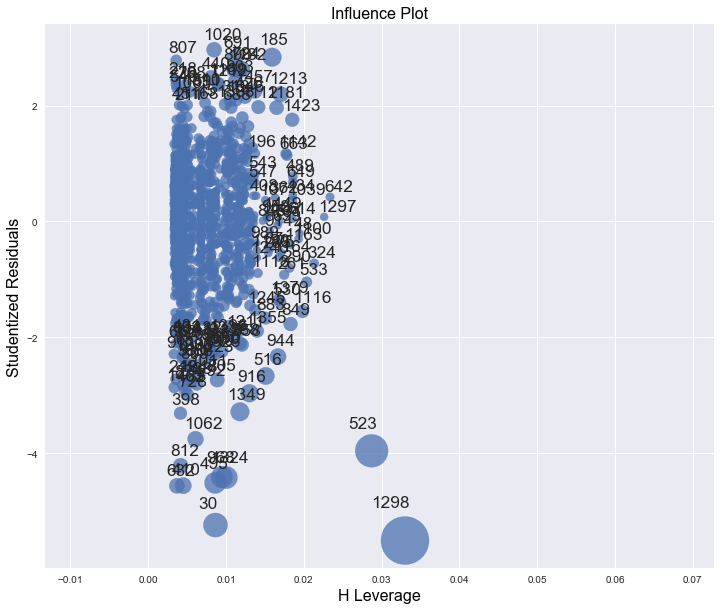

In [146]:
# Examine leverage. 1298 and 523 have huge influence. Might want to consider removing them.
fig, ax = plt.subplots(figsize=(12,10))
sns.set(font_scale= 1) 
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")

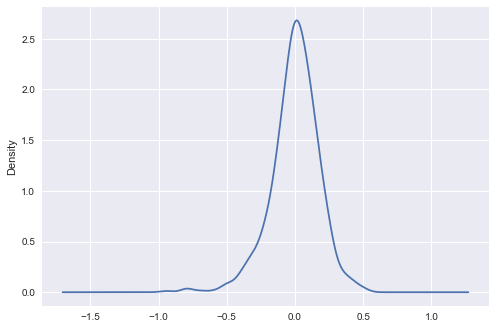

In [147]:
#check for normality. Looks normal.
plt.figure()

results.resid.plot.density()
plt.show()

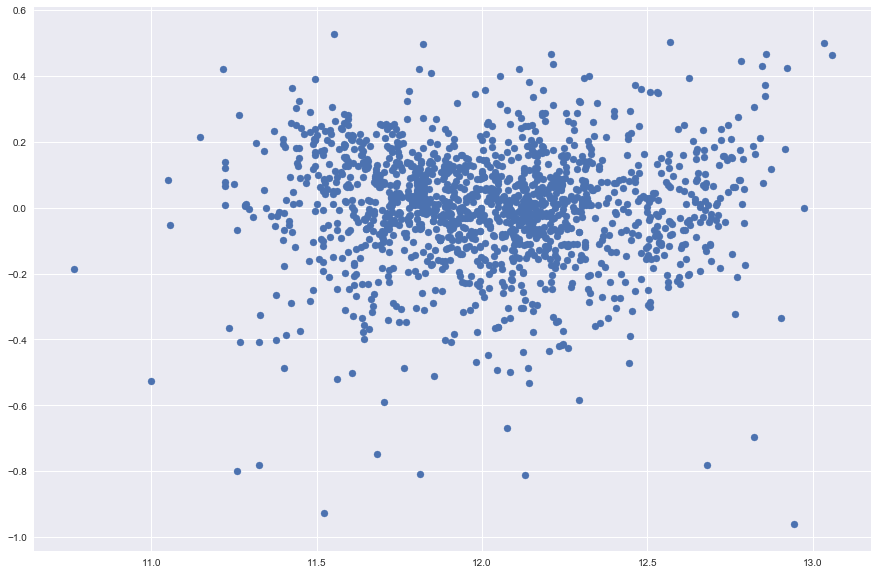

In [148]:
#Plot residuals against fitted values. Residuals seem to vary more as we move from the center.
fig, ax = plt.subplots(figsize=(15,10))
fig = plt.scatter(results.fittedvalues, results.resid)

<p><a name="kaggle_1"></a></p>
### Submission to Kaggle (Linear Regression 1) 
### Note: No adjustments to outliers/influential points or skewness were made
    1. Transforming the Test Variables
    2. Make Predictions 
    3. Save Results

In [ ]:
set(test_sub["SaleCondition"])

In [ ]:
#Group HouseStyle variable by 1stFloor, 2ndFloor, and Split and count frequency. 1Story and 2Story close.

def hstyle(c):
    if c['HouseStyle'] == "1Story":
        return '1Story'
    elif c['HouseStyle'] in ["SFoyer", "SLvl"]:
        return 'Split'
    else:
        return '2Story'

test_sub['House_Group'] = test_sub.apply(hstyle, axis=1)
test_sub.groupby("House_Group").size()

In [ ]:
#Add column that groups OverallQual into thirds

def overall_qual(c):
    if c['OverallQual'] <= 4:
        return 'Low'
    elif c['OverallQual'] > 7:
        return 'High'
    else:
        return 'Medium'

test_sub['Qual_Group'] = test_sub.apply(overall_qual, axis=1)
test_sub.groupby("Qual_Group").size()

In [ ]:
#Add column that groups SaleCondition into thirds

def saleCond(c):
    if c['SaleCondition'] == "Partial":
        return 'Partial'
    else:
        return 'Non_partial'

test_sub['SaleCond_Group'] = test_sub.apply(saleCond, axis=1)
test_sub.groupby("SaleCond_Group").size()

In [ ]:
#join neighborhood key with the test set; x is the data frame containing the key.
new_df = pd.merge(test_sub, x, how='left', on = ["Neighborhood", "Neighborhood"])

In [ ]:
test_sub = new_df.drop(["quartiles"], axis = 1)
test_sub.head()

In [ ]:
#dummify Neigh_Group
df = test_sub.copy()
hood = pd.get_dummies(df['Neigh_Group'], prefix='Neigh', prefix_sep='__')
hood = hood.drop('Neigh__1', axis=1)
hood.head()
df = pd.concat([df.drop('Neigh_Group', axis=1), hood], axis=1)

In [ ]:
#dummify HouseStyle
df = df.copy()
style = pd.get_dummies(df['House_Group'], prefix='Style', prefix_sep='__')
style = style.drop('Style__1Story', axis=1)
df = pd.concat([df.drop('House_Group', axis=1), style], axis=1)

In [ ]:
#dummify OverallQual
df = df.copy()
qual = pd.get_dummies(df['Qual_Group'], prefix='Qual', prefix_sep='__')
qual = qual.drop('Qual__Low', axis=1)
df = pd.concat([df.drop('Qual_Group', axis=1), qual], axis=1)

In [ ]:
#dummify SaleCond
df = df.copy()
saleCond = pd.get_dummies(df['SaleCond_Group'], prefix='saleCond', prefix_sep='__')
saleCond = saleCond.drop('saleCond__Non_partial', axis=1)
df = pd.concat([df.drop('SaleCond_Group', axis=1), saleCond], axis=1)

In [ ]:
#Select five variables to make predictions
X5_test = pd.concat([df[["GrLivArea"]],df[df.columns[-8:]]], axis = 1)

In [ ]:
#Make predictions
X5_test = sm.add_constant(X5_test)
y_test = np.exp(results.predict(X5_test))
y_test = pd.DataFrame({'SalePrice': y_test})

In [ ]:
submission_1 = pd.concat([test_ID, y_test], axis = 1)

In [ ]:
#write to csv file. Result: 0.19168
submission_1.to_csv("submission_1.csv", index=False)

<p><a name="outliers_1"></a></p>

### Examine Outliers and Datapoints with Big Influence

In [149]:
#Examine datapoints 523 and 1298. It seems like these two data points have very high grlivarea but low sale price.
#Was it because of financial crisis? Observation 1298 was sold in 2008.
X_all.iloc[[523, 1298],:]

,const,GrLivArea,Neigh__2,Neigh__3,Neigh__4,Style__2Story,Style__Split,Qual__High,Qual__Medium,saleCond__Partial
523,1.0,3.546178,0,0,0,1,0,1,0,1
1298,1.0,4.109391,0,0,0,1,0,1,0,1


In [150]:
train_df.iloc[[523,1298],:]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


<p><a name="linear1_nooutliers"></a></p>

### Perform Linear Regression 1 without observations 523 and 1298

In [151]:
X5b = X5.copy()
X5b.to_csv('XTrain_Wing.csv', index = False, header = True)



In [152]:
#remove observations 523 and 1298
X5b = X5b.drop(X5b.index[[523,1298]])

In [153]:
X5b.iloc[520:526]

,GrLivArea,Neigh__2,Neigh__3,Neigh__4,Style__2Story,Style__Split,Qual__High,Qual__Medium,saleCond__Partial
520,-0.306748,0,0,0,1,0,0,0,0
521,-0.424930,1,0,0,0,0,0,1,0
522,0.447478,0,0,0,1,0,0,1,0
524,1.543372,0,0,1,1,0,0,1,0
525,-0.372355,0,0,1,0,0,0,1,0
526,-1.303826,1,0,0,0,0,0,1,0


In [154]:
#remove corresponding sales price
yb = y.copy()
yb= yb.drop(yb.index[[523,1298]])

In [155]:
#Split train_sub into train and test and fit 2nd linear model on train:

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X5b, yb, test_size=0.2, random_state=8)

In [156]:
y_test.shape

(292,)

In [157]:
#Fit 2nd linear model to train set and test against test set
#Results better than first model. R^2 does not change that much between train and test set.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
rms_train =  np.sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
rms_test =  np.sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))


Root mean squared error for train set: 0.178719
R^2 for train set: 0.807719
**************************************************
Root mean squared error for test set: 0.164110
R^2 for test  set: 0.796541


In [158]:
#Performing same analysis as above using Statsmodel. Based on Cond. No., it seems like multi-collinearity is not
#an issue.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     539.6
Date:                Sat, 11 Nov 2017   Prob (F-statistic):               0.00
Time:                        14:44:45   Log-Likelihood:                 353.30
No. Observations:                1166   AIC:                            -686.6
Df Residuals:                    1156   BIC:                            -636.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.7133      0.02

In [160]:
#Train on entire dataset
X_all = sm.add_constant(X5b)
model_final = sm.OLS(yb, X_all)
results = model_final.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     671.6
Date:                Sat, 11 Nov 2017   Prob (F-statistic):               0.00
Time:                        14:45:19   Log-Likelihood:                 466.91
No. Observations:                1458   AIC:                            -913.8
Df Residuals:                    1448   BIC:                            -861.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                11.7127      0.01

In [175]:
#Calculate RMSE 
rmse = np.sqrt(mean_squared_error(results.fittedvalues,yb))
"RMSE is: %f" %rmse

'RMSE is: 0.175665'

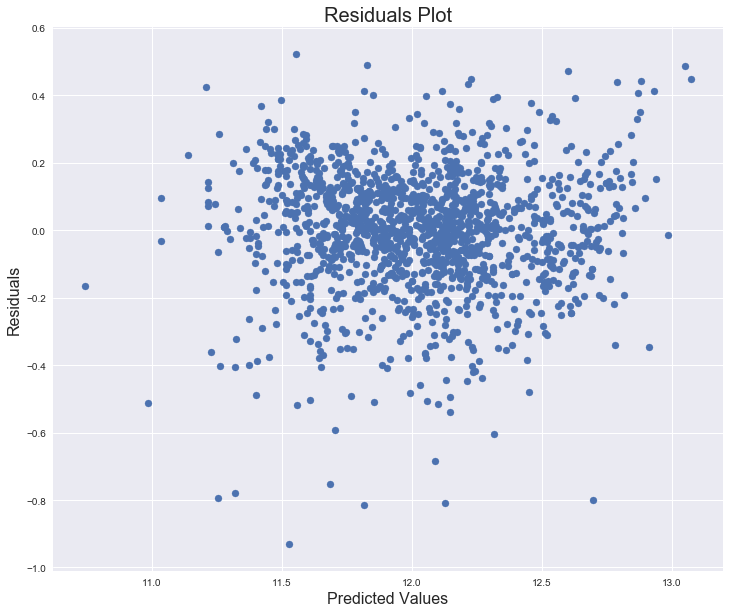

In [170]:
#Plot residuals against fitted values. Residuals seem to vary more as we move from the center.
fig, ax = plt.subplots(figsize=(12,10))
plt.xlabel('Predicted Values', fontsize=16)
plt.ylabel('Residuals', fontsize=16)
plt.title('Residuals Plot', fontsize = 20)
fig = plt.scatter(results.fittedvalues, results.resid)

<p><a name="kaggle_1b"></a></p>
### Resubmission to Kaggle (Linear Regression 1)  with Outliers Removed
    1. Make Predictions 
    2. Save Results

In [ ]:
#Make predictions
X5_test = sm.add_constant(X5_test)
y_test = np.exp(results.predict(X5_test))-1
y_test = pd.DataFrame({'SalePrice': y_test})

In [ ]:
submission_1b = pd.concat([test_ID, y_test], axis = 1)

In [ ]:
#write to csv file. Result: 0.18804
submission_1b.to_csv("submission_1b.csv", index=False)

<p><a name="economy"></a></p>

## EDA: Relationship between Sale Price and Economic Cycle/Financial Crisis

In [ ]:
#Histogram of YearSold
print(X_TRAIN["YrSold"].describe())
plt.hist(X_TRAIN["YrSold"], bins=10) 

In [ ]:
#combine month and year sold columns
from datetime import datetime
df_copy = X_TRAIN[['MoSold','YrSold']]
Y = np.array(df_copy['YrSold']-1970, dtype='<M8[Y]')
m = np.array(df_copy['MoSold']-1, dtype='<m8[M]')
d = np.ones(1,dtype='<m8[D]')
dates2 = pd.DataFrame(Y+m+d)
dates2.rename(columns = {0: 'Date'}, inplace = True)

In [ ]:
df = pd.concat([dates2,train_df['SalePrice']], axis = 1)
df.head()

In [ ]:
#Cant' really see a downward trend.
plt.figure(figsize=(15,12))
sns.swarmplot(x = 'Date', y = 'SalePrice', data=df)

In [ ]:
df_copy = pd.concat([X5, df, X_TRAIN['Neighborhood']], axis = 1)
df_copy.head()

In [ ]:
#swarmplot with colors based on Neigh_Group 1(which includes Edwards) versus others.
#A couple of big outliers from this group and houses seem to be sold around the same time in groups.
plt.figure(figsize=(15,12))
colors = np.where((df_copy["Neigh__2"]+df_copy["Neigh__3"] + df_copy["Neigh__4"] ==0) ,'red','white')
plot = sns.swarmplot(x = 'Date', y = 'SalePrice', data=df_copy, palette = colors)
plt.show()

In [ ]:
#swarmplot with colors based on Neigh_Group 1(which includes Edwards) versus others.
#A couple of big outliers from this group and houses seem to be sold around the same time in groups.
plt.figure(figsize=(15,12))
colors = np.where((df_copy["Neigh__2"]+df_copy["Neigh__3"] + df_copy["Neigh__4"] ==0) ,'red','white')
price_sf = df_copy['SalePrice']/train_df['GrLivArea']
plot = sns.swarmplot(x = 'Date', y = price_sf, data=df_copy, palette = colors)
plt.show()

In [ ]:
del df, df_copy

<p><a name="eda_cars"></a></p>

## EDA and Feature Engineering of GarageCars

Before substituting GarageCars for GrLivArea, the following EDA analyses were performed to assess its 
relationship with the other variables. GarageCars is then dummified and assessed for its multicollinearity
with the other variables using a VIF analysis.

In [ ]:
df_copy['SalePrice']

In [ ]:
#What if we include GarageCars in the model? Does this improve it? First, let's see what it's correlation is 
#like with the other explanatory variables.

#GarageCars does seem to be correlated with the neighborhood groups.

cars_hood_table = pd.crosstab(index=train_sub["Neigh_Group"], 
                          columns=train_sub["GarageCars"])
cars_hood_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

In [ ]:
#Not so much with House_Group.
cars_house_table = pd.crosstab(index=train_sub["House_Group"], 
                          columns=train_sub["GarageCars"])
cars_house_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

In [ ]:
#High quality homes have more garages it seems on average
cars_quality_table = pd.crosstab(index=train_sub["Qual_Group"], 
                          columns=train_sub["GarageCars"])
cars_quality_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

In [ ]:
#Inconclusive relationship between GarageCars and SaleCond
cars_salecond_table = pd.crosstab(index=train_sub["SaleCond_Group"], 
                          columns=train_sub["GarageCars"])
cars_salecond_table.plot(kind="bar", 
                 figsize=(6,6),
                 stacked=True)

In [ ]:
#Does substituting GarageCars for GrFlrArea reduce RMSE while not creating multicollinearity issues? First,
#let's dummify the variable
df = df.copy()
cars = pd.get_dummies(df['GarageCars'], prefix='Cars', prefix_sep='__')
cars = cars.drop('Cars__0', axis=1)
df = pd.concat([df, cars], axis=1)


In [ ]:
#Split train_sub into train and test and fit 2nd linear model on train:

X5 = df[df.columns[-12:]]

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X5, y, test_size=0.2, random_state=8)

<p><a name="linear2"></a></p>

## Linear Regression 2

Linear regression using the following variables: "GarageCars", "Neighborhood", "OverallQual", 
"HouseStyle", "SaleCondition".

In [ ]:
#2nd Linear Regression. RMSE goes down from 1st model.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))


In [ ]:
#Checking VIFs. All are below 5.
vif = [variance_inflation_factor(X5.values, i) for 
       i in range(X5.shape[1])]
print("VIF for all the variables:")
list(zip(vif, X5.columns))

In [ ]:
#Performing same analysis as above using Statsmodel. AIC and BIC numbers improve relative to 3rd model and 
#multi-collinearity doesn't seem to be an issue. It appears that we can't reject null that coefficient for
#Style_Split is different from 0.

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

<p><a name="linear3"></a></p>
## Linear Regression 3: Using all 20 Variables (excluding GrLivArea)

<p><a name="VIF2"></a></p>
### Variance Inflation Factor
Calculate the VIF for all the variables using statsmodel.

In [ ]:
#Checking VIFs. Many high VIFs
C = X.copy().drop('GrLivArea', axis = 1)
vif = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

l = list(zip(vif, C.columns))
l = sorted(l, reverse = True)
l_names = [x[1] for x in l]
l


In [ ]:
for i in range(50):
    C = C.drop(l_names[i], axis = 1)
    i = i +1

In [ ]:

vif = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

l = list(zip(vif, C.columns))
l = sorted(l, reverse = True)
l_names = [x[1] for x in l]
l


In [ ]:
for i in range(5):
    C = C.drop(l_names[i], axis = 1)
    i = i +1

In [ ]:
vif = [variance_inflation_factor(C.values, i) for i in range(C.shape[1])]

l = list(zip(vif, C.columns))
l = sorted(l, reverse = True)
l_names = [x[1] for x in l]
l


In [ ]:
#Set X equal to the reduced data frame
X56 = C
X56.shape

<p><a name="run_linear3"></a></p>
### Linear Regression 3
Fit model with the reduced set of 56 variables

In [ ]:
#Split train_sub into train and test and fit 2nd linear model on train:

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X56, y, test_size=0.2, random_state=8)

In [ ]:
y

In [ ]:
#Regression result worse than previous one.

ols = linear_model.LinearRegression()

ols.fit(X_train, y_train)

y_predicted_train = ols.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))

y_predicted_test = ols.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))

print("Root mean squared error for train set: %f" %rms_train)
print("R^2 for train set: %f" %ols.score(X_train, y_train))

print("*"*50)

print("Root mean squared error for test set: %f" %rms_test)
print("R^2 for test  set: %f" %ols.score(X_test, y_test))


In [ ]:
#Performing same analysis as above using Statsmodel. It appears that we can't reject null that coefficients are zero
#for quite a few variables. 

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

In [ ]:
# fit model to entire dataset

ols = linear_model.LinearRegression()

ols.fit(X52, y)

y_predicted = ols.predict(X52)
mse = mean_squared_error(y, y_predicted)
rms = np.sqrt(mean_squared_error(y, y_predicted))


print("Root mean squared error for entire dataset: %f" %rms)
print("R^2 for entire dataset: %f" %ols.score(X52, y))


In [ ]:
#Doing the same in Statsmodel
X52 = sm.add_constant(X52)
model = sm.OLS(y, X52)
results = model.fit()
print(results.summary())


<p><a name="residuals_lin"></a></p>
### Residuals Analysis for Linear Regression 3
Examine the residuals of the final model fitted in the previous linear regression.





In [ ]:
# Examine leverage. 635 has huge influence and several outliers in the bottom of chart.
fig, ax = plt.subplots(figsize=(20,20))
fig = sm.graphics.influence_plot(results, ax=ax, criterion="cooks")

In [ ]:
#check for normality. Looks normal.
plt.figure()

results.resid.plot.density()
plt.show()

In [ ]:
#Plot residuals against fitted values. Residuals seem to vary more as we move from the center.
fig, ax = plt.subplots(figsize=(15,10))
fig = plt.scatter(results.fittedvalues, results.resid)

<p><a name="ridge"></a></p>
## Ridge Analysis using all 20 Variables 

In [ ]:
# Drop observations 523 and 1298

Xb = X.copy()
#remove observations 523 and 1298
Xb = Xb.drop(Xb.index[[523,1298]])

In [ ]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xb, yb, test_size=0.2, random_state=8)

In [ ]:
def rmse_cv(model,x, y):
    rmse= np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [ ]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = " Cross Validation Ridge")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
#Best alpha and rmse
best =cv_ridge[cv_ridge == cv_ridge.min()]
best_alpha = best.index[0]
print(best_alpha)

In [ ]:
#Fitting to entire training subset using best alpha
Ridge_best = Ridge(alpha = best_alpha)
Ridge_best.fit(X_train, y_train)
print("Ridge training R-squared is: %f" %Ridge_best.score(X_train, y_train))

y_predicted_train = Ridge_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Ridge training RMSE is: %f" %rms_train)

In [ ]:
#Test model against test set. 

y_predicted_test = Ridge_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Ridge test R-squared is: %f" %Ridge_best.score(X_test, y_test))
print("Ridge test RMSE is: %f" %rms_test)

In [ ]:
#Fitting to entire training set
Ridge_final = Ridge(alpha = best_alpha)
Ridge_final.fit(Xb, yb)
print("Ridge R-squared on entire training set is: %f" %Ridge_best.score(Xb, yb))

y_predicted = Ridge_final.predict(Xb)
mse = mean_squared_error(yb, y_predicted)
rms = np.sqrt(mean_squared_error(yb, y_predicted))
print("Ridg RMSE is: %f" %rms)

In [ ]:
Ridge_final.get_params()

In [ ]:
<p><a name="kaggle_2"></a></p>
### Submission to Kaggle (Ridge Regression)
    1. Make Predictions 
    2. Save Results

In [ ]:
#Make predictions
y_test = Ridge_final.predict(X_kaggle)
y_test = np.expm1(y_test)
y_test = pd.DataFrame({'SalePrice': y_test})

In [ ]:
submission_2 = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.14897
submission_2.to_csv("submission_2.csv", index=False)

In [ ]:
submission_2.describe()

<p><a name="residuals_ridge"></a></p>
### Residuals and Influence Analysis


In [ ]:
#Residuals vs. Fitted Values. Probably same outliers again in the upper right
residuals = y_predicted - yb
fig, ax = plt.subplots(figsize=(15,10))
fig = plt.scatter(y_predicted, residuals)

<p><a name="impVar_ridge"></a></p>
### Important Variables Analysis

In [ ]:
#to be filled in

<p><a name="gridsearch"></a></p>
### Second Method: Grid Search Function

In [ ]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xb, yb, test_size=0.2, random_state=8)

In [ ]:
from sklearn.model_selection import GridSearchCV
model = Ridge()
grid_param = [{'alpha': np.logspace(0, 2, 100)}]
grid = GridSearchCV(estimator=model, param_grid=grid_param).fit(X_train, y_train)
print(grid)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

In [ ]:
best_alpha2 = grid.best_estimator_.alpha

#Fitting to entire training subset using best alpha
Ridge_best2 = Ridge(alpha = best_alpha2)
Ridge_best2.fit(X_train, y_train)
print("Ridge training R-squared is: %f" %Ridge_best2.score(X_train, y_train))

y_predicted_train = Ridge_best2.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Ridge training RMSE is: %f" %rms_train)

In [ ]:
#Test model against test set. R^2 and RMSE improved.

y_predicted_test = Ridge_best2.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Ridge test R-squared is: %f" %Ridge_best2.score(X_test, y_test))
print("Ridge test RMSE is: %f" %rms_test)

In [ ]:
#Fitting to entire training set
Ridge_final2 = Ridge(alpha = best_alpha2)
Ridge_final2.fit(Xb, yb)
print("Ridge R-squared on entire training set is: %f" %Ridge_best2.score(Xb, yb))

y_predicted2 = Ridge_final2.predict(Xb)
mse = mean_squared_error(yb, y_predicted2)
rms = np.sqrt(mean_squared_error(yb, y_predicted2))
print("Ridg RMSE is: %f" %rms)

<p><a name="lasso"></a></p>
## Lasso Analysis Using All 20 Variables


In [ ]:
# Drop observations 523 and 1298

Xb = X.copy()
#remove observations 523 and 1298
Xb = Xb.drop(Xb.index[[523,1298]])

In [ ]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xb, yb, test_size=0.2, random_state=8)

In [ ]:
# LassoCV
model_lasso = Lasso()
alphas = np.logspace(-3, 3, 100)
cv_lasso = [rmse_cv(Lasso(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

In [ ]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_ridge.plot(title = " Cross Validation Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
#Best alpha is .001. So small.
print(cv_lasso)
print(cv_lasso.min())

In [ ]:
#Fitting to entire training subset using alpha = .001
Lasso_best = Lasso(alpha = .001)
Lasso_best.fit(X_train, y_train)
print("Lasso training R-squared is: %f" %Lasso_best.score(X_train, y_train))

y_predicted_train = Lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Lasso training RMSE is: %f" %rms_train)

In [ ]:
#There may be overfitting issues. The metrics improved a bit.
y_predicted_test = Lasso_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Lasso test R-squared is: %f" %Lasso_best.score(X_test, y_test))
print("Lasso test RMSE is: %f" %rms_test)

In [ ]:
#Fitting to entire training set. Improves again. 
Lasso_final = Lasso(alpha = .001)
Lasso_final.fit(Xb, yb)
print("Lasso R-squared on entire training set is: %f" %Lasso_best.score(Xb, yb))

y_predicted = Lasso_final.predict(Xb)
mse = mean_squared_error(yb, y_predicted)
rms = np.sqrt(mean_squared_error(yb, y_predicted))
print("Lasso RMSE is: %f" %rms)

<p><a name="kaggle_3"></a></p>
### Submission to Kaggle (Lasso Regression)
    1. Make Predictions 
    2. Save Results

In [ ]:
#Make predictions
y_test = np.exp(Lasso_final.predict(X_kaggle))-1
y_test = pd.DataFrame({'SalePrice': y_test})

In [ ]:
submission_3 = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.15026
submission_3.to_csv("submission_3.csv", index=False)

In [ ]:
submission_3.describe()

<p><a name="lasso2"></a></p>
## Lasso Regression 2
- Rerun Lasso with reduced columns

In [ ]:
#Delete Features that seem to be highly correlated: 1stFlrSF, 2ndFlrSF, GarageCond, SaleType, TotRmsAbvGrd
filter_col = [col for col in X if col.startswith(('GarageCond','SaleType', 'TotRmsAbvGrd','1st', '2nd'))]
X2 = X.drop(filter_col, axis = 1)
X2 = X2.drop(X2.index[[523,1298]])

filter_col = [col for col in X_kaggle if col.startswith(('GarageCond','SaleType', 'TotRmsAbvGrd','1st', '2nd'))]
X_kaggle2 = X_kaggle.drop(filter_col, axis = 1)

In [ ]:
#Delete Neighborhood, OverallQual, HouseStyle SaleCondition 
filter_col = [col for col in X if col.startswith(('Neighborhood','OverallQual', 'HouseStyle','SaleCondition'))]
X2 = X2.drop(filter_col, axis = 1)

filter_col = [col for col in X_kaggle if col.startswith(('Neighborhood','OverallQual', 'HouseStyle','SaleCondition'))]
X_kaggle2 = X_kaggle2.drop(filter_col, axis = 1)

In [ ]:
#Replace Neighborhood, OverallQual, HouseStyle SaleCondition with my groupings

X2 = pd.concat([X2, X5b.drop('GrLivArea', axis = 1)], axis = 1)
X_kaggle2 = pd.concat([X_kaggle2, X5_test.drop('GrLivArea', axis = 1)], axis = 1)

In [ ]:
# Create training and test sets

try:  # train_test_split was moved in 0.18.0
    from sklearn.model_selection import train_test_split
except:  # Following import works through 0.19 but outputs a warning in 0.18
    from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, yb, test_size=0.2, random_state=8)

In [ ]:
# LassoCV
model_lasso = Lasso()
alphas = np.logspace(-3, 3, 100)
cv_lasso = [rmse_cv(Lasso(alpha = alpha), X_train, y_train).mean() for alpha in alphas]

In [ ]:
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_ridge.plot(title = " Cross Validation Lasso")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [ ]:
#Best alpha is .001. So small.
print(cv_lasso)
print(cv_lasso.min())

In [ ]:
#Fitting to entire training subset using alpha = .001
Lasso_best = Lasso(alpha = .001)
Lasso_best.fit(X_train, y_train)
print("Lasso training R-squared is: %f" %Lasso_best.score(X_train, y_train))

y_predicted_train = Lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, y_predicted_train)
rms_train = np.sqrt(mean_squared_error(y_train, y_predicted_train))
print("Lasso training RMSE is: %f" %rms_train)

In [ ]:
#There may be overfitting issues. The metrics improved a bit.
y_predicted_test = Lasso_best.predict(X_test)
mse_test = mean_squared_error(y_test, y_predicted_test)
rms_test = np.sqrt(mean_squared_error(y_test, y_predicted_test))
print("Lasso test R-squared is: %f" %Lasso_best.score(X_test, y_test))
print("Lasso test RMSE is: %f" %rms_test)

In [ ]:
#Fitting to entire training set. Improves again. 
Lasso_final = Ridge(alpha = .001)
Lasso_final.fit(X2, yb)
print("Lasso R-squared on entire training set is: %f" %Lasso_best.score(X2, yb))

y_predicted = Lasso_final.predict(X2)
mse = mean_squared_error(yb, y_predicted)
rms = np.sqrt(mean_squared_error(yb, y_predicted))
print("Lasso RMSE is: %f" %rms)

<p><a name="kaggle_3b"></a></p>
### Submission to Kaggle (Lasso Regression)
    1. Make Predictions 
    2. Save Results

In [ ]:
#Make predictions
y_test = np.exp(Lasso_final.predict(X_kaggle2))-1
y_test = pd.DataFrame({'SalePrice': y_test})

In [ ]:
submission_3b = pd.concat([test_ID, y_test], axis = 1)

#write to csv file. Result: 0.15717
submission_3b.to_csv("submission_3b.csv", index=False)

In [ ]:
#Are the coefficients significantly different from 0?

<p><a name="residuals_lasso"></a></p>
### Residuals and Influence Analysis

In [ ]:
#Any assumption violations? 

<p><a name="impVar_lasso"></a></p>
### Important Variables Analysis

In [ ]:
#Which are the important variables

In [ ]:
train_sub.head()